<a href="https://colab.research.google.com/github/Ness731/3-Min-Deeplearning/blob/main/chapter_5_%EC%9D%B4%EB%AF%B8%EC%A7%80_%EC%B2%98%EB%A6%AC_%EB%8A%A5%EB%A0%A5%EC%9D%B4_%ED%83%81%EC%9B%94%ED%95%9C_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Chapter.5 이미지 처리 능력이 탁월한 CNN

### __CNN (Convolutional neural network)__
- __CNN이란?__<br>
CNN은 이미지나 비디오 같은 영상 인식에 특화된 설계로, 병렬 처리가 쉬워서 대규모 서비스에 적용할 수 있다.

- __CNN을 사용하는 이유는?__<br>
일반적인 인공 신경망은 다양한 형태의 입력에 대한 확장성이 떨어진다. 또한, 앞서 배운 torchvision이 transforms 도구를 사용하여 학습 데이터를 변형시키는 방식은 처리해야 하는 데이터의 개수가 매우 커지므로, 모든 경우의 수를 다 고려하여 학습 데이터에 반영하는 것은 불가능하다.

- __CNN의 원리__<br>
사람은 이미지를 보는 순간 이미지 속의 계층적인 특성을 바로 인식하며, 이러한 특징들을 모아 사물을 인식하는 것이다. 이러한 원리를 그대로 적용한 것이 CNN으로, 모델이 사물을 계층적으로 인식할 수 있도록 단계마다 이미지의 특징을 추출한다. 특징을 추출할 때에는 __'필터(filter)'__라는 도구를 사용한다.<br>
또한, 필터를 적용할 때 이미지 왼쪽 위에서 오른쪽 밑까지 밀어가며 곱하고 더하는 작업을 수행하며, 이러한 작업을 __'컨볼루션(convolution)'__이라고 한다. 컨볼루션 작업을 통해 이미지의 특징을 추출한 후에는 중요한 특징만을 걸러내는 작업이 필요하며, 이를 __'풀링(pooling)'__이라고 한다. 풀링 작업에서는 덜 중요한 특징을 버리기 때문에, 결과 데이터는 __차원이 감소__하게 된다.
  - `filter` : 이미지의 특징을 추출하는 도구
  - `convolution` : 필터를 적용할 때 수행하는 행렬 연산
  - `pooling` : 컨볼루션 후에 중요한 특징만을 추출하는 작업

> 풀링 또한 컨볼루션 연산의 일종이다. 풀링은 필터가 지나갈 때마다 픽셀을 묶어서 __평균(average pooling)__이나 __최댓값(max pooling)__을 가져오는 간단한 연산으로 이루어진다.

### __Convolution calculation__
Convolution을 하는 도구가 바로 __커널(kernel)__ 또는 필터(filter)이다. 커널은 데이터로부터 어떤 성질을 뽑아낼지 결정한다.
1. 이미지를 작은 조각으로 쪼갠다.
2. 커널(또는 필터) 기능을 하는 작은 신경망에 적용한다.
3. 커널을 통과한 결과를 모아 __특징 맵(feature map)__을 생성한다.
> 이때, 특징맵의 크기가 크면 학습이 어렵고 과적합의 위험이 증가한다.

- __커널을 적용하기 전 입력__
  - 원본 이미지 크기
  - 결과물 이미지 크기
  - 커널 크기
  - `stride` : 커널이 얼만큼의 간격으로 움직일지(stride가 1인 경우 unit stride라고도 한다)
  - `zero padding` : 이미지의 외부에 얼마나 많은 pixel을 0으로 채워넣을 것인지 (실제 이미지보다 더 큰 이미지를 고려할 때 사용한다)
    - half padding : 입력 이미지 크기와 출력 이미지 크기가 동일하도록 패딩 처리
    - full padding : 패딩을 최대로 적용하는 것. 최소 1개의 픽셀이라도 커널에 걸리도록 padding을 주면 된다.

- __결과물 이미지 크기__<br>
= [(원본 이미지 크기 + 2 * 제로 패딩 - 커널 크기) / 스트라이드] + 1<br>
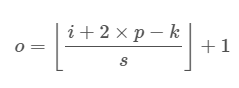

In [10]:
# 1. 라이브러리 import
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision # 데이터를 불러오면서 전처리하기 위한 라이브러리
from torchvision import transforms, datasets

import matplotlib.pyplot as plt # 데이터 시각화
import numpy as np # 행렬연산

In [11]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

In [12]:
EPOCHS = 40
BATCH_SIZE = 64

In [13]:
train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('./.data', train=True, download=True, transform=transforms.Compose([
      transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081))
    ])),
    batch_size = BATCH_SIZE, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('./.data', train=False, transform=transforms.Compose([
      transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081))
    ])),
    batch_size = BATCH_SIZE, shuffle=True
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 1, 28, 28])
torch.Size([64])


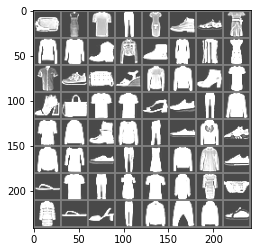

In [14]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))

- __nn.Conv2d()__ : 컨볼루션 레이어.
  - 첫 번째 파라미터 : 입력 채널 수 (숫자 하나만 입력시 정사각형으로 간주한다.)
  - 두 번째 파라미터 : 출력 채널 수
- __nn.Dropout2d()__ : 드롭아웃 인스턴스

In [15]:
class CNN(nn.Module):
  def __init__(self):
    # 컨볼루션 계층
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 10, kernel_size = 5) # fasion MNIST 데이터는 흑백이므로 입력 채널이 1이다.
    self.conv2 = nn.Conv2d(10, 20, kernel_size = 5) # 첫 번째 Conv를 통과한 결과 데이터는 채널이 10이므로, 입력 채널의 크기는 10.
    self.drop = nn.Dropout2d()

    # 일반 신경망
    self.fc1 = nn.Linear(320, 50)
    self.fc2 = nn.Linear(50, 10) # 보편적으로 레이어를 거칠수록 차원 수를 줄여나간다.

  def forward(self, x):
    # 1. 컨볼루션 계층 통과
    x = F.relu(F.max_pool2d(self.conv1(x), 2)) # 커널 사이즈가 2인 풀링
    x = F.relu(F.max_pool2d(self.conv2(x), 2))
    
    # 2. 데이터 차원 축소
    x = x.view(-1, 320)

    # 3. 신경망 통과
    x = F.relu(self.fc1(x))
    x = self.drop(x)
    x = self.fc2(x)
    return x

In [16]:
model = CNN().to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum = 0.5)

In [17]:
def train(model, train_loader, optimizer, epoch):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(DEVICE), target.to(DEVICE)
    optimizer.zero_grad()
    output = model(data)
    loss = F.cross_entropy(output, target)
    loss.backward()
    optimizer.step()

    if batch_idx % 200 == 0: # 일정한 주기로 결과 출력
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss:{:.6f}'.format(epoch, batch_idx * len(data),
                                                                    len(train_loader.dataset),
                                                                    100. * batch_idx / len(train_loader),
                                                                    loss.item()))

In [18]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)

            # 배치 오차를 합산
            test_loss += F.cross_entropy(output, target,
                                         reduction='sum').item()

            # 가장 높은 값을 가진 인덱스가 바로 예측값
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [19]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, epoch)
    test_loss, test_accuracy = evaluate(model, test_loader)
    
    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(
          epoch, test_loss, test_accuracy))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Train Epoch: 1 [0/60000 (0%)]	Loss:2.364583
Train Epoch: 1 [12800/60000 (21%)]	Loss:1.608242
Train Epoch: 1 [25600/60000 (43%)]	Loss:1.805943
Train Epoch: 1 [38400/60000 (64%)]	Loss:1.500938
Train Epoch: 1 [51200/60000 (85%)]	Loss:1.433299
[1] Test Loss: 0.7856, Accuracy: 76.99%
Train Epoch: 2 [0/60000 (0%)]	Loss:1.626857
Train Epoch: 2 [12800/60000 (21%)]	Loss:1.686485
Train Epoch: 2 [25600/60000 (43%)]	Loss:1.444466
Train Epoch: 2 [38400/60000 (64%)]	Loss:1.478913
Train Epoch: 2 [51200/60000 (85%)]	Loss:1.220752
[2] Test Loss: 0.6678, Accuracy: 81.38%
Train Epoch: 3 [0/60000 (0%)]	Loss:1.326862
Train Epoch: 3 [12800/60000 (21%)]	Loss:1.138386
Train Epoch: 3 [25600/60000 (43%)]	Loss:1.472464
Train Epoch: 3 [38400/60000 (64%)]	Loss:1.375701
Train Epoch: 3 [51200/60000 (85%)]	Loss:1.340340
[3] Test Loss: 0.5873, Accuracy: 82.46%
Train Epoch: 4 [0/60000 (0%)]	Loss:1.436695
Train Epoch: 4 [12800/60000 (21%)]	Loss:1.153389
Train Epoch: 4 [25600/60000 (43%)]	Loss:1.138117
Train Epoch: 4 [38